# Mujoco basics

This code is adapted from the
[tutorial](https://colab.research.google.com/github/deepmind/mujoco/blob/main/python/tutorial.ipynb#scrollTo=T5f4w3Kq2X14) and can be consulted for more details.

Make sure mujoco is installed.

In [2]:
# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
!pip install mujoco
import mediapy as media
import matplotlib.pyplot as plt

Installing mediapy:


In [3]:
import mujoco

In [4]:
import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

/tmp/ipykernel_241754/3954759137.py:1: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.util


Wed Jul 26 15:30:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...    On | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8               N/A /  50W|     48MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## mjModel

In [5]:
model_path = "/home/rlins/Git/research/rlmjc/src/envs/mujoco/models/box.xml"

# Mujoco Model
model = mujoco.MjModel.from_xml_path(model_path)

In [6]:
# Accessors can be used to calling geoms by name string
try:
  model.geom()
except KeyError as e:
  print(e)

"Invalid name ''. Valid names: ['box', 'ground']"


In [7]:
# Names can also be accessed via python comprehensions
[model.geom(i).name for i in range(model.ngeom)]

['ground', 'box']

## mjData

In [8]:
# Make data containing time, position, velocities among other informations
data = mujoco.MjData(model)

In [9]:
data.geom_xpos

array([[0., 0., 0.],
       [0., 0., 0.]])

Wait, why are both of our geoms at the origin? Didn't we offset the green sphere? The answer is that derived quantities in mjData need to be explicitly propagated (see below). In our case, the minimal required function is mj_kinematics, which computes global Cartesian poses for all objects (excluding cameras and lights).

In [10]:
mujoco.mj_kinematics(model, data)
print('raw access: \n', data.geom_xpos)


raw access: 
 [[0.  0.  0. ]
 [0.  0.  0.4]]


## Basic rendering, simulation and animation


In [11]:
# Reload to make intedependet section
model = mujoco.MjModel.from_xml_path(model_path)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

A visualization session can be launched like simulate binary

In [12]:
# Managed viewer
# mujoco.viewer.launch(model, data)

In [13]:
# import keyboard

# def on_key_event(event):
#     if event.name == 'esc':
#         keycode = event.scan_code

#     return keycode
    
# keycode = keyboard.on_press(on_key_event)

For more controle, passive viewer can be used to user’s timing and advancing the physics state, and mouse-drag perturbations. It will not work unless the user explicitly synchronizes incoming events.

In [14]:
# #TODO: Is returning an error after closing
# import time

# import mujoco.viewer 
# import numpy as np

# # Passive viewer
# with mujoco.viewer.launch_passive(model, data) as viewer:
#     while viewer.is_running():
#         # stepping the physics
#         mujoco.mj_step(model, data)
        
#         # Example modification of a viewer option: toggle contact points every two seconds.
#         with viewer.lock():
#             viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(data.time % 2)
        
#         # Pick up changes to the physics state, apply perturbations, update options from GUI.
#         viewer.sync()
    
#     viewer.close()

""

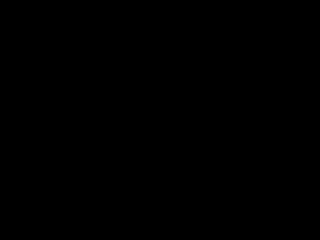

In [15]:
# Using mediapy
media.show_image(renderer.render())

Hmmm, why the black pixels?

Answer: For the same reason as above, we first need to propagate the values in mjData. This time we'll call mj_forward, which invokes the entire pipeline up to the computation of accelerations i.e., it computes  x˙=f(x) , where  x  is the state. This function does more than we actually need, but unless we care about saving computation time, it's good practice to call mj_forward since then we know we are not missing anything.

We also need to update the mjvScene which is an object held by the renderer describing the visual scene. We'll later see that the scene can include visual objects which are not part of the physical model.

""

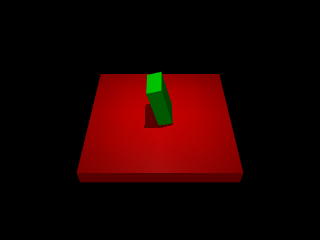

In [16]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

# Simulation

In [17]:
duration = 3.8  #  (seconds)
framerate = 60  #  (Hz)

frames = []

mujoco.mj_resetData(model, data)

while data.time < duration:
    mujoco.mj_step(model, data)
    
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)

In [18]:
duration = 3.8  #  (seconds)
framerate = 60  #  (Hz)

frames = []

mujoco.mj_resetData(model, data)
model.opt.gravity[2] = 0.81
while data.time < duration:
    mujoco.mj_step(model, data)
    
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)

In [19]:
# Understanding degrees of freedon
print(f"Total number of DoFs in the model: {model.nv}")
print(f"Generalized position: {data.qpos}")
print(f"Generalized velocities: {data.qvel}")

Total number of DoFs in the model: 6
Generalized position: [-7.76511817e-03 -1.14603742e-17  6.40807319e+00  9.99161822e-01
 -4.25492558e-17  4.09347393e-02  2.52810976e-19]
Generalized velocities: [-2.02497502e-03 -2.90773294e-18  3.22496665e+00 -2.21800726e-17
  2.15630542e-02 -3.51815160e-19]


## Example: More complex model tippe-top

""

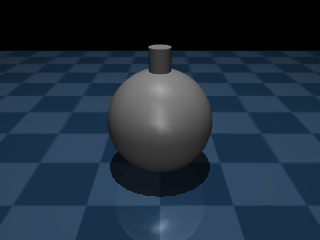

In [37]:
model_path = "/home/rlins/Git/research/rlmjc/src/envs/mujoco/models/tipped_top.xml"

del model
del renderer
del data

model = mujoco.MjModel.from_xml_path(model_path)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)

mujoco.mj_forward(model, data)

renderer.update_scene(data, camera="closeup")
media.show_image(renderer.render())

In [35]:
duration = 7 
framerate = 60

frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)

while data.time < duration:
    mujoco.mj_step(model, data)
   
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="closeup")
        frame = renderer.render()
        frames.append(frame)

media.show_video(frames)

Text(0.5, 0, 'time (seconds)')

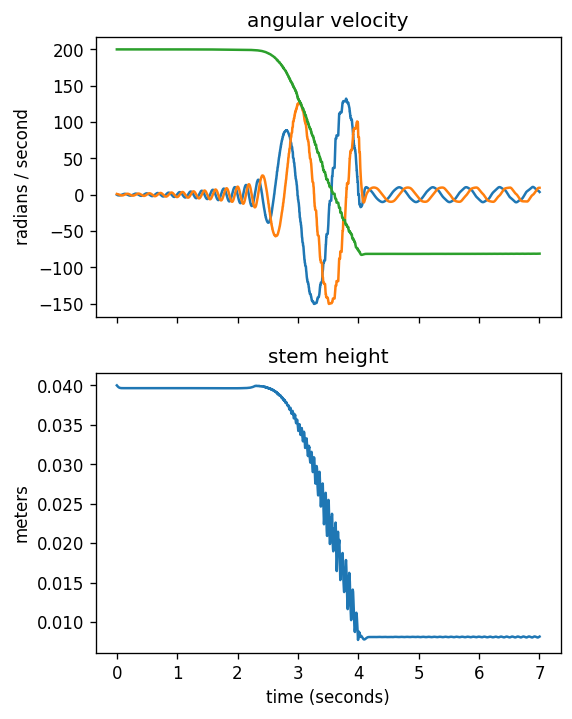

In [41]:
timevals = []
angular_vel = []
stem_height = []

mujoco.mj_resetData(model, data)
mujoco.mj_resetDataKeyframe(model, data, 0)

while data.time < duration:
    mujoco.mj_step(model, data)
    
    timevals.append(data.time)
    angular_vel.append(data.qvel[3:6].copy())
    stem_height.append(data.geom_xpos[2, 2])
    
# figure configuration
dpi = 120
width = 600
height = 800
figsize = (width/dpi, height/dpi)

_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_vel)
ax[0].set_title("angular velocity")
ax[0].set_ylabel("radians / second")

ax[1].plot(timevals, stem_height)
ax[1].set_title("stem height")
ax[1].set_ylabel("meters")
ax[1].set_xlabel("time (seconds)")

In [43]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="6 6"
     texuniform="true" reflectance=".2"/>
     <material name="wall" rgba='.5 .5 .5 1'/>
  </asset>

  <default>
    <geom type="box" size=".05 .05 .05" />
    <joint type="free"/>
  </default>

  <worldbody>
    <light name="light" pos="-.2 0 1"/>
    <geom name="ground" type="plane" size=".5 .5 10" material="grid"
     zaxis="-.3 0 1" friction=".1"/> 
    <camera name="y" pos="-.1 -.6 .3" xyaxes="1 0 0 0 1 2"/>
    <body pos="0 0 .1">
      <joint/>
      <geom/>
    </body>
    <body pos="0 .2 .1">
      <joint/>
      <geom friction=".33"/>
    </body>
  </worldbody>

</mujoco>
"""
n_frames = 60
height = 300
width = 300
frames = []

del model, data, renderer

# load
model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height, width)

# simulate and render
mujoco.mj_resetData(model, data)
for i in range(n_frames):
  while data.time < i/30.0:
    mujoco.mj_step(model, data)
  renderer.update_scene(data, "y")
  frame = renderer.render()
  frames.append(frame)
media.show_video(frames, fps=30)